### 필요 라이브러리 import
---

In [59]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import cv2 
import os
import time

from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation
from tensorflow import data
from tensorflow.keras import layers, Input, Model
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from matplotlib import pyplot as plt
from IPython import display

### 데이터 불러오기 및 전처리
---
pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.

In [30]:
data_path = os.getenv('HOME')+'/aiffel/conditional_generation/data/cityscapes/'
train_data_path = data_path+'train/'
val_data_path = data_path+'val/'
print(train_data_path)

print("number of train examples :", len(os.listdir(train_data_path)))
print("number of validation examples :", len(os.listdir(val_data_path)))

/aiffel/aiffel/conditional_generation/data/cityscapes/train/
number of train examples : 1000
number of validation examples : 5


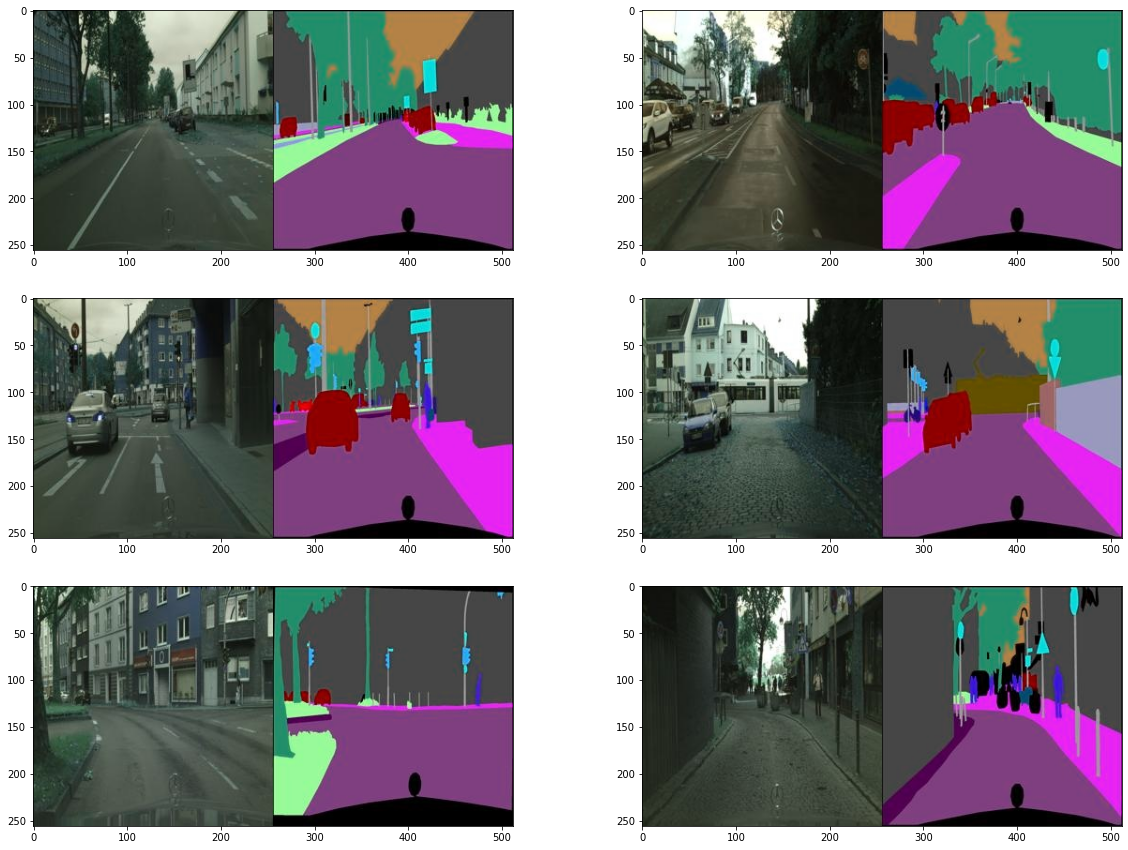

In [31]:
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = train_data_path + os.listdir(train_data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

이미지 크기 확인

In [32]:
f = train_data_path + os.listdir(train_data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


이미지 2개로 분할하여 사용

In [33]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

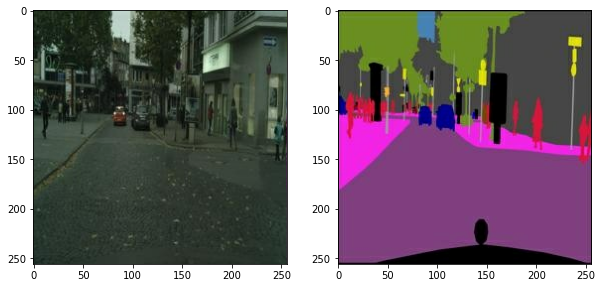

In [34]:
f = train_data_path + os.listdir(train_data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [35]:
!/opt/conda/bin/python3.7 -m pip install --upgrade pip

In [36]:
!pip install tensorflow-gpu

augmentation을 이용하여 데이터셋 증가\
이미지 회전, 자르기, 뒤집기 적용

In [87]:
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

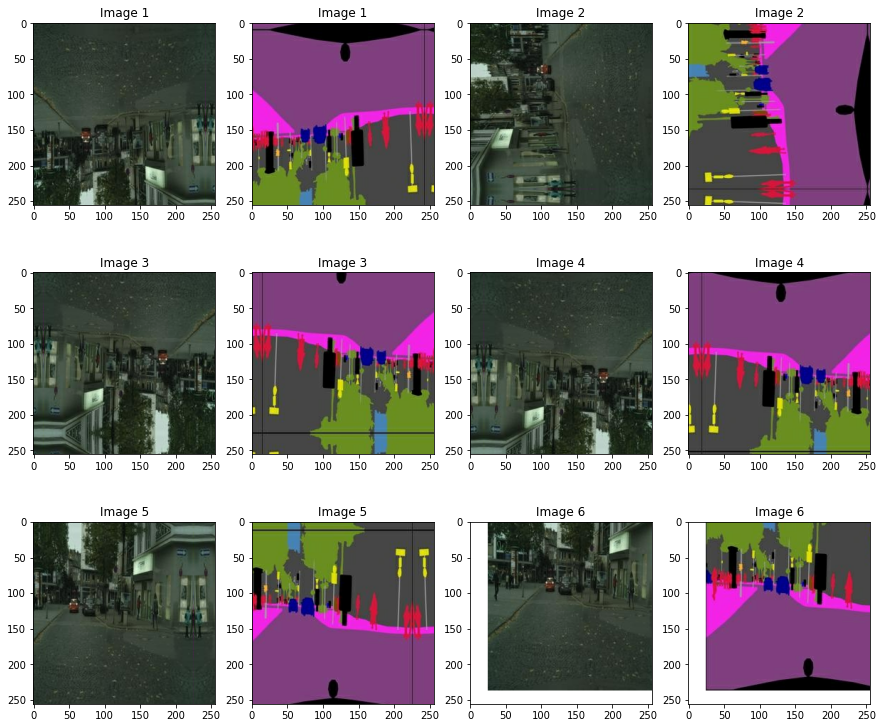

In [39]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

In [40]:
def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

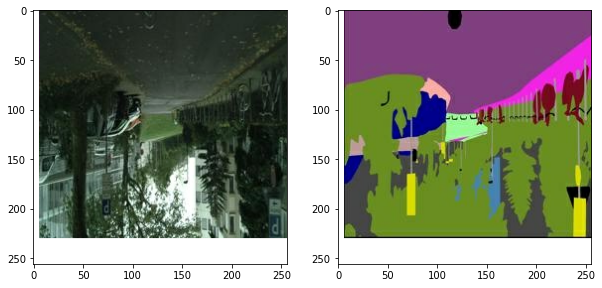

In [60]:
train_images = data.Dataset.list_files(train_data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

### Generator 구성
---
pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다.\
U-Net generator 모델

In [86]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [85]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [62]:
Encoder().get_summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block_16 (EncodeBlock (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_17 (EncodeBlock (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_18 (EncodeBlock (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_19 (EncodeBlock (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_20 (EncodeBlock (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_21 (EncodeBlock (None, 4, 4, 512)         4196

In [84]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [64]:
Decoder().get_summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block_14 (DecodeBlock (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_15 (DecodeBlock (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_16 (DecodeBlock (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_17 (DecodeBlock (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_18 (DecodeBlock (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_19 (DecodeBlock (None, 64, 64, 128)       5248

In [83]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [66]:
UNetGenerator().get_summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_24 (EncodeBlock)   (None, 128, 128, 64) 3072        input_9[0][0]                    
__________________________________________________________________________________________________
encode_block_25 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_24[0][0]            
__________________________________________________________________________________________________
encode_block_26 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_25[0][0]            
____________________________________________________________________________________________

### Discriminator 구성
---
Discriminator 모델

In [82]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [68]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d_5 (ZeroPaddin (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_67 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_41 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [81]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [70]:
Discriminator().get_summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_16 (Concatenate)    (None, 256, 256, 6)  0           input_11[0][0]                   
                                                                 input_12[0][0]                   
__________________________________________________________________________________________________
disc_block_10 (DiscBlock)       (None, 128, 128, 64) 6144        concatenate_16[0][0]       

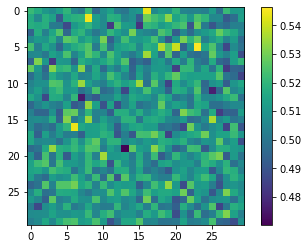

In [71]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

### 모델 학습
---
학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.

In [78]:
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [79]:
gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)


In [80]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss


In [76]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.9658                     
L1_loss:0.2931                     
Discriminator_loss:1.2118

EPOCH[1] - STEP[20]                     
Generator_loss:0.9841                     
L1_loss:0.2572                     
Discriminator_loss:1.0131

EPOCH[1] - STEP[30]                     
Generator_loss:1.6308                     
L1_loss:0.3086                     
Discriminator_loss:1.3984

EPOCH[1] - STEP[40]                     
Generator_loss:1.4556                     
L1_loss:0.2781                     
Discriminator_loss:0.6411

EPOCH[1] - STEP[50]                     
Generator_loss:1.4829                     
L1_loss:0.2905                     
Discriminator_loss:0.5483

EPOCH[1] - STEP[60]                     
Generator_loss:1.8551                     
L1_loss:0.3055                     
Discriminator_loss:0.4547

EPOCH[1] - STEP[70]                     
Generator_loss:2.2727                     
L1_loss:0.2617                    

EPOCH[3] - STEP[70]                     
Generator_loss:2.2391                     
L1_loss:0.1799                     
Discriminator_loss:0.3565

EPOCH[3] - STEP[80]                     
Generator_loss:2.5862                     
L1_loss:0.1835                     
Discriminator_loss:1.0215

EPOCH[3] - STEP[90]                     
Generator_loss:1.4345                     
L1_loss:0.2230                     
Discriminator_loss:0.4780

EPOCH[3] - STEP[100]                     
Generator_loss:2.4765                     
L1_loss:0.1613                     
Discriminator_loss:1.0710

EPOCH[3] - STEP[110]                     
Generator_loss:3.2391                     
L1_loss:0.1922                     
Discriminator_loss:0.7617

EPOCH[3] - STEP[120]                     
Generator_loss:1.3947                     
L1_loss:0.1980                     
Discriminator_loss:0.8801

EPOCH[3] - STEP[130]                     
Generator_loss:2.4294                     
L1_loss:0.2293                

EPOCH[5] - STEP[130]                     
Generator_loss:1.6768                     
L1_loss:0.2224                     
Discriminator_loss:0.7854

EPOCH[5] - STEP[140]                     
Generator_loss:1.8640                     
L1_loss:0.1695                     
Discriminator_loss:1.3181

EPOCH[5] - STEP[150]                     
Generator_loss:1.3636                     
L1_loss:0.2063                     
Discriminator_loss:0.6407

EPOCH[5] - STEP[160]                     
Generator_loss:2.0755                     
L1_loss:0.2044                     
Discriminator_loss:0.3340

EPOCH[5] - STEP[170]                     
Generator_loss:2.2796                     
L1_loss:0.2344                     
Discriminator_loss:0.6597

EPOCH[5] - STEP[180]                     
Generator_loss:1.4979                     
L1_loss:0.2322                     
Discriminator_loss:0.4137

EPOCH[5] - STEP[190]                     
Generator_loss:0.6638                     
L1_loss:0.2346             

EPOCH[7] - STEP[190]                     
Generator_loss:1.2379                     
L1_loss:0.1541                     
Discriminator_loss:0.7984

EPOCH[7] - STEP[200]                     
Generator_loss:1.6225                     
L1_loss:0.1909                     
Discriminator_loss:0.5749

EPOCH[7] - STEP[210]                     
Generator_loss:1.9048                     
L1_loss:0.1647                     
Discriminator_loss:0.5620

EPOCH[7] - STEP[220]                     
Generator_loss:1.7779                     
L1_loss:0.1983                     
Discriminator_loss:0.4397

EPOCH[7] - STEP[230]                     
Generator_loss:0.5613                     
L1_loss:0.1975                     
Discriminator_loss:1.6518

EPOCH[7] - STEP[240]                     
Generator_loss:2.3703                     
L1_loss:0.1766                     
Discriminator_loss:0.8042

EPOCH[7] - STEP[250]                     
Generator_loss:0.4887                     
L1_loss:0.2206             

EPOCH[9] - STEP[250]                     
Generator_loss:2.2619                     
L1_loss:0.1692                     
Discriminator_loss:0.6501

EPOCH[10] - STEP[10]                     
Generator_loss:1.8185                     
L1_loss:0.1706                     
Discriminator_loss:0.8556

EPOCH[10] - STEP[20]                     
Generator_loss:0.7591                     
L1_loss:0.1791                     
Discriminator_loss:1.1526

EPOCH[10] - STEP[30]                     
Generator_loss:1.1607                     
L1_loss:0.1879                     
Discriminator_loss:1.0733

EPOCH[10] - STEP[40]                     
Generator_loss:2.8071                     
L1_loss:0.2207                     
Discriminator_loss:0.1727

EPOCH[10] - STEP[50]                     
Generator_loss:1.5986                     
L1_loss:0.1797                     
Discriminator_loss:0.4548

EPOCH[10] - STEP[60]                     
Generator_loss:3.5676                     
L1_loss:0.1759             

시각화 결과

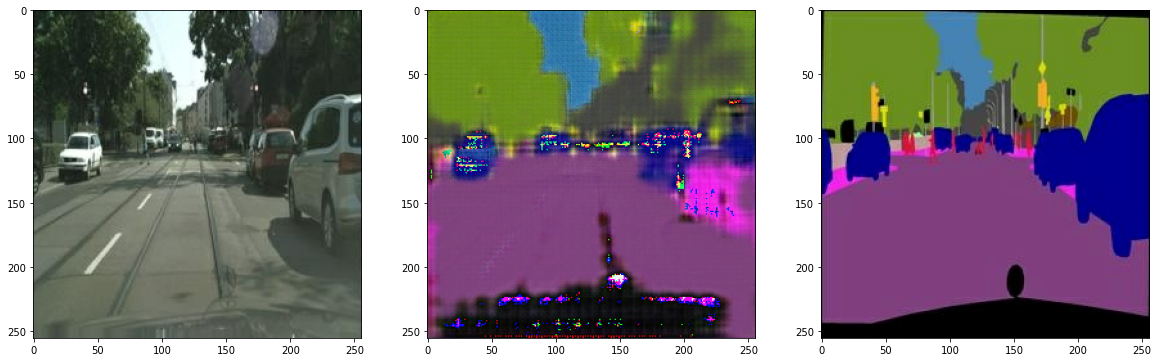

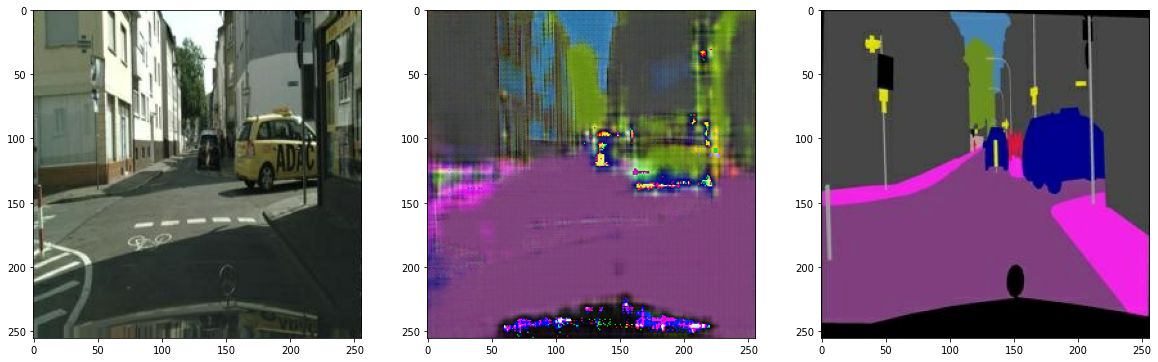

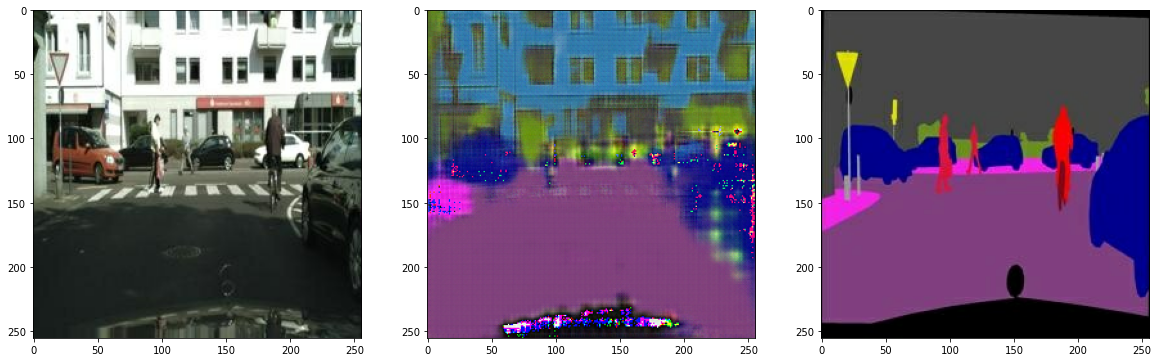

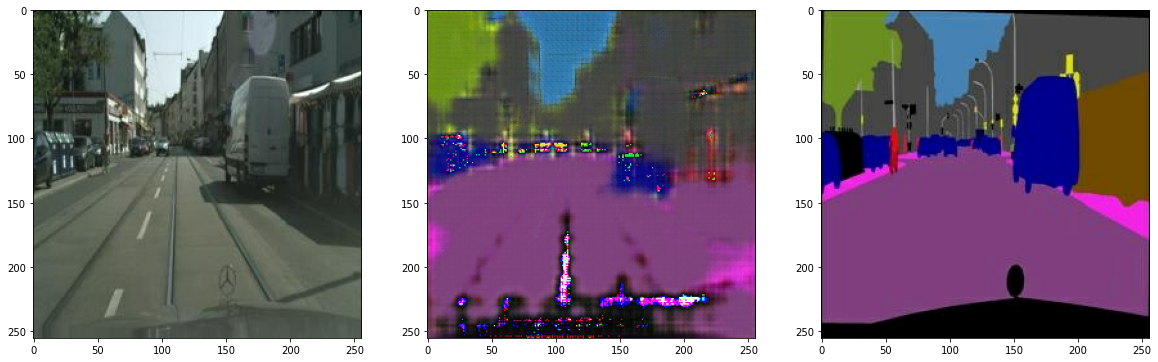

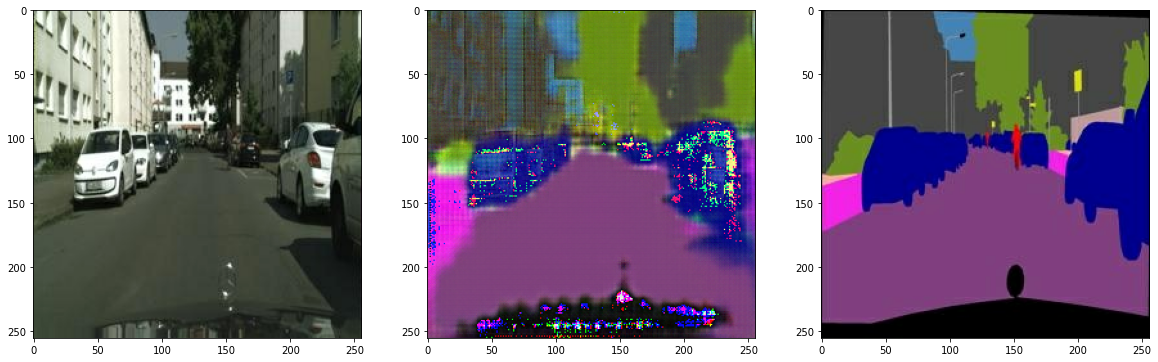

In [77]:
test_ind = 1

for i in range(len(os.listdir(val_data_path))):
    f = val_data_path + os.listdir(val_data_path)[i]
    sketch, colored = load_img(f)

    pred = generator(tf.expand_dims(sketch, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
    plt.subplot(1,3,2); plt.imshow(pred[0])
    plt.subplot(1,3,3); plt.imshow(denormalize(colored))

### 회고
---
Gan의 생성 과정에서 노이즈로 인한 불안정함을 해소하는 모델을 배웠다는 점에서 의미있는 노드로 다가옵니다.\
수식에 대해서는 아직 이해가 부족한데, 이는 시간을 들여서 이해도를 높여야 할 것 같습니다.\
